# load the data 

In [7]:
import numpy as np
import pandas as pd

In [8]:
# ds = data set 
ds = pd.read_csv("HW3Data.csv")
ds.head()

,0,2.080754,1.099069,0.927763,1.029081,-0.130763,1.26546,-0.436286,0.728881,2.107979,...,-0.825403,-0.138451,0.382957,0.876697,-0.216234,-1.4083,0.393327,-0.148522,1.591533,-0.217481
0,1,1.109457,0.786453,0.445560,-0.146323,-0.996316,0.555759,0.290734,-0.145259,1.132660,...,-1.056288,-0.205499,-1.815374,0.324373,-1.296909,-0.870757,1.108739,1.094010,-0.492141,-1.554079
1,0,-0.676530,1.693100,1.559247,1.559983,-0.982179,-1.358507,-1.313994,-0.455067,0.295214,...,1.242968,1.230157,-2.038999,2.366093,0.820656,1.404501,0.176860,-0.086285,-0.390878,-0.089465
2,1,0.534396,1.677537,1.489030,0.778605,-0.183776,-1.116850,-1.487557,-0.579511,0.292683,...,0.559852,-0.593149,-4.440577,1.720705,-0.124617,-0.435880,0.228440,-0.893938,1.005879,-0.631247
3,0,-1.018903,0.511080,0.755641,1.013816,0.529899,0.160440,-0.087055,1.295290,0.458736,...,0.227110,0.497628,-0.083921,-0.382733,-0.913389,1.122928,0.834571,-0.283786,-2.860340,0.280871
4,1,-1.185369,-0.514473,-0.566634,1.224720,0.619244,-0.684713,-0.798129,1.368770,-0.697007,...,0.926855,0.302304,0.302785,-1.170087,-1.189162,0.418884,-2.247347,-0.455263,-1.528083,0.327891


In [9]:
ds.shape

(61, 2001)

In [10]:
x=ds.iloc[:,1:2000].values
y=ds.iloc[:,0].values


# Recursive Feature Elimination method (REF) with cross-validation

In [12]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(10),
              scoring='accuracy')
rfecv.fit(x,y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Optimal number of features : 59


<Figure size 640x480 with 1 Axes>

# splittng slected features into training and test sets 

In [13]:
rfecv.transform(x).shape

(61, 59)

In [26]:
from sklearn.model_selection import train_test_split
z=rfecv.transform(x)
Y=ds.iloc[:,0].values

z_train, z_test, Y_train, Y_test = \
    train_test_split(z, Y, 
                     test_size=0.10,
                     stratify=Y,
                     random_state=1)

# holdout method (we use 10-k folds) 

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(random_state=1))

pipe_lr.fit(z_train, Y_train)
y_pred = pipe_lr.predict(z_test)
print('Test Accuracy: %.3f' % pipe_lr.score(z_test, Y_test))

Test Accuracy: 1.000


In [28]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
    

kfold = StratifiedKFold(n_splits=10,
                        random_state=1).split(z_train, Y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(z_train[train], Y_train[train])
    score = pipe_lr.score(z_train[test], Y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(Y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores))) 

Fold:  1, Class dist.: [31 17], Acc: 0.833
Fold:  2, Class dist.: [31 17], Acc: 0.833
Fold:  3, Class dist.: [31 17], Acc: 0.833
Fold:  4, Class dist.: [31 17], Acc: 1.000
Fold:  5, Class dist.: [31 17], Acc: 0.833
Fold:  6, Class dist.: [32 17], Acc: 0.600
Fold:  7, Class dist.: [32 17], Acc: 1.000
Fold:  8, Class dist.: [32 17], Acc: 0.800
Fold:  9, Class dist.: [32 17], Acc: 1.000
Fold: 10, Class dist.: [32 18], Acc: 1.000

CV accuracy: 0.873 +/- 0.123


# learning curve for selected features 

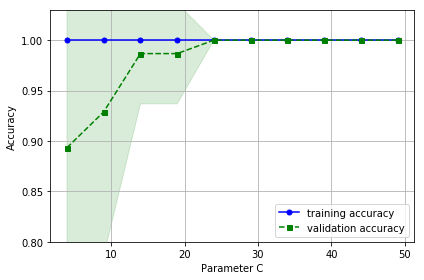

In [29]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(penalty='l2', random_state=1))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr ,
                               X=z_train,
                               y=Y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=15,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
#plt.savefig('images/06_05.png', dpi=300)
plt.show()

# validation curve for selected features

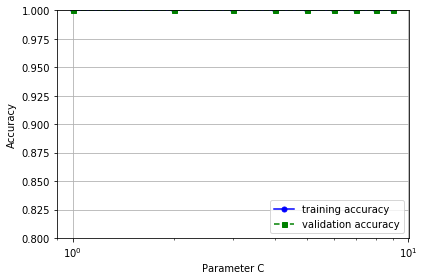

In [30]:
from sklearn.model_selection import validation_curve


param_range = [i for i in range (1,10) ]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=z_train, 
                y=Y_train, 
                param_name='logisticregression__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('images/06_06.png', dpi=300)
plt.show()